# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
from timeit import default_timer as timer
import pandas as pd
import shutil
import pathlib
import sys
from skimage.exposure import rescale_intensity
#import rsnapsim as rss
from skimage.measure import find_contours
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')
masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')
# Importing rSNAPed
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [3]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [4]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1 # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 40     # PLEASE TEST MIN 5 MAX 200
diffusion_coefficient = 0.3    # PLEASE TEST MIN 0.1 MAX 2
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'linear_interpolation' #'linear_interpolation' # Options are: 'constant' , 'shuffle' and 'loop' 'linear_interpolation'
save_as_gif= True

particle_size = 7 # spot size for the simulation and tracking.
elongation_rate = 10
initiation_rate = 0.03

# Perturbations
simulation_time_in_sec = 30    
perturbation_time_start = 0
perturbation_time_stop = 0

# Intensity scale
intensity_scale_ch0 = 300
intensity_scale_ch1 = 500
intensity_scale_ch2 = None

particle_detection_size = particle_size
use_Harringtonin=0
use_FRAP=0

## Running the simulations

In [5]:
def fun_simulated_cells(current_dir, video_dir,masks_dir=None,ke=3,ki=0.03,gene_file =None, trajectories_dir=None, number_of_simulated_cells=3,number_spots_per_cell=80,
    simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',
    intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video,
    perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP,save_as_gif=False ):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        output_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        selected_video = 4
        video_path = path_files[selected_video]        
        video = imread(video_path) 
        # Loading the mask image
        if not (masks_dir is None):
            mask_image=imread(masks_dir.joinpath('mask_cell_shape_'+str(selected_video)+'.tif'))       
        else:
            mask_image=None
        # Reducing in a half the intensity in the original video
        empty_videos = video
        counter +=1
        if counter>=len(path_files):
            counter =0
        if not (trajectories_dir is None ):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectories_dir))
            random_index_ch0 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            
            simulated_trajectories_ch0 = ssa_trajectories[random_index_ch0,0:simulation_time_in_sec:step_size_in_sec] / 10 # converting to ump
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec] / 10 # converting to ump
            simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec] / 10 # converting to ump
        else:
            # Simulations for intensity
            ssa1,ssa1_ump,_ = rsp.SSA_rsnapsim(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP, perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop).simulate() # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch1 = ssa1_ump
            ssa2,ssa2_ump,_ =  rsp.SSA_rsnapsim(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP, perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop).simulate() # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch2 = ssa2_ump
            simulated_trajectories_ch0 = simulated_trajectories_ch1
        #simulated_trajectories_ch0 = None
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        _ , _, _ = rsp.SimulatedCell( base_video=video, mask_image=mask_image, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=save_as_gif, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=0,frame_selection_empty_video=frame_selection_empty_video ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos

In [6]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos = fun_simulated_cells(current_dir,video_dir,masks_dir=masks_dir,ke=elongation_rate, ki=initiation_rate,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP,save_as_gif=save_as_gif)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

Time to generate simulated data: 13  sec


In [7]:
output_directory_name

PosixPath('/home/luisub/Desktop/rsnaped/notebooks/Simulated_Cell/temp/Simulation_V2__ns_40_diff_0_3')

## Display results as images

In [8]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
# Reading the microscopy data
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

## <span style="color:red">Channel 0</span>

mean intensity in image:  1026.6


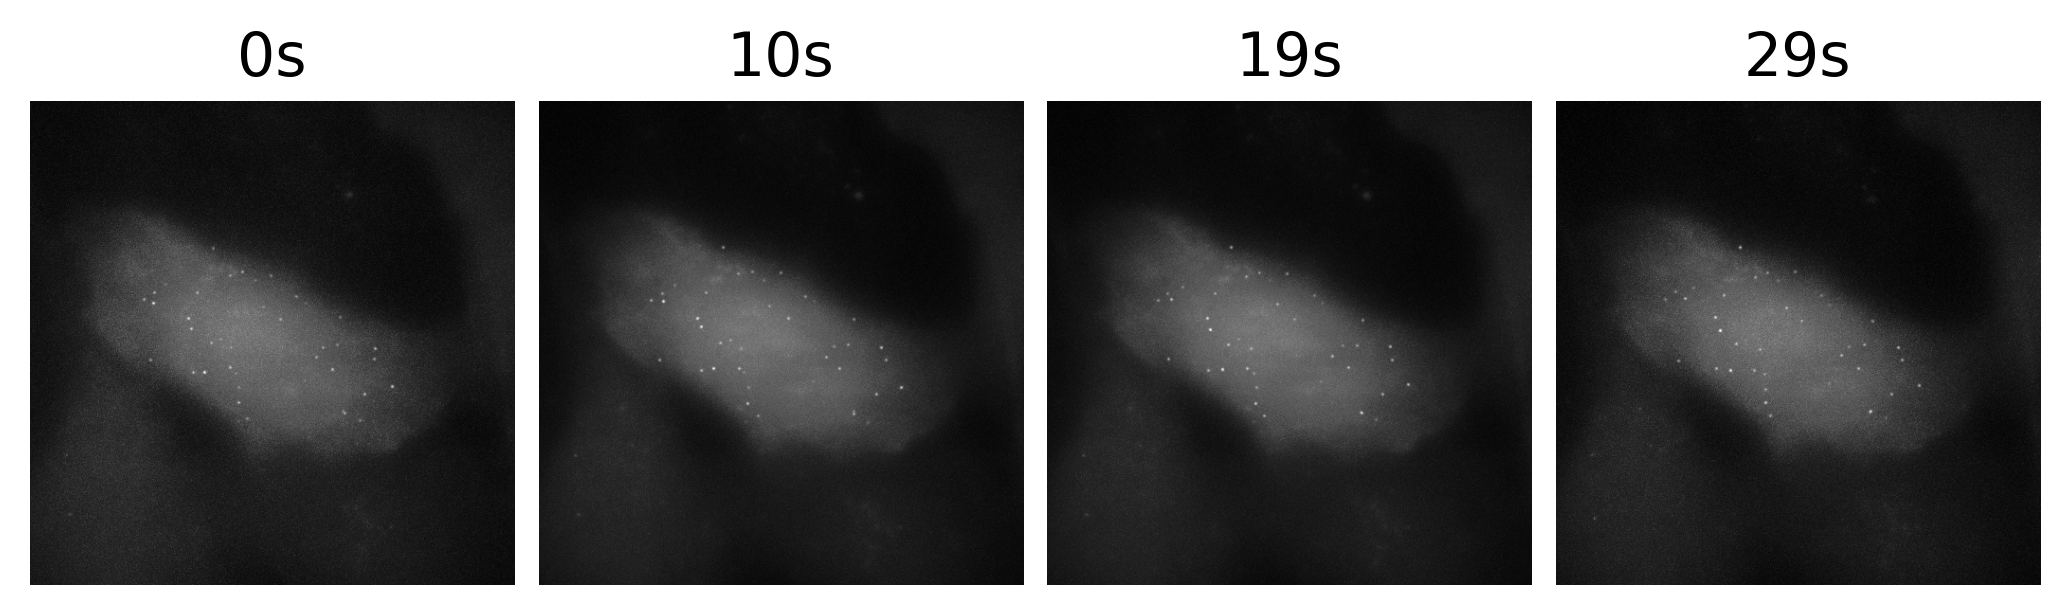

In [9]:
ncrops = 4
time_vector = np.round(np.linspace(0,simulation_time_in_sec-1,ncrops)).astype(int)

ncrops = len(time_vector)
time_vector
channel = 0
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 2))
max_val=[]
min_val=[]
for i in range(0, ncrops):
    temp_img= list_videos[0][time_vector[i],:,:,channel]
    max_val.append(np.amax(temp_img))
    min_val.append(np.amin(temp_img))# running the simulation
print('mean intensity in image: ', np.round(temp_img.mean(),1))

for i in range(0, ncrops):
    axes[i].imshow(list_videos[0][time_vector[i],:,:,channel],cmap='Greys_r', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')
    axes[i].set(title= str(time_vector[i]) + 's')
#name_figure = name_files+'_cells.png'
#figure_directory = str(dropbox_address.joinpath(name_figure ) )

plt.tight_layout() 
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()

## <span style="color:lightgreen">Channel 1</span>

mean intensity in image:  2659.7


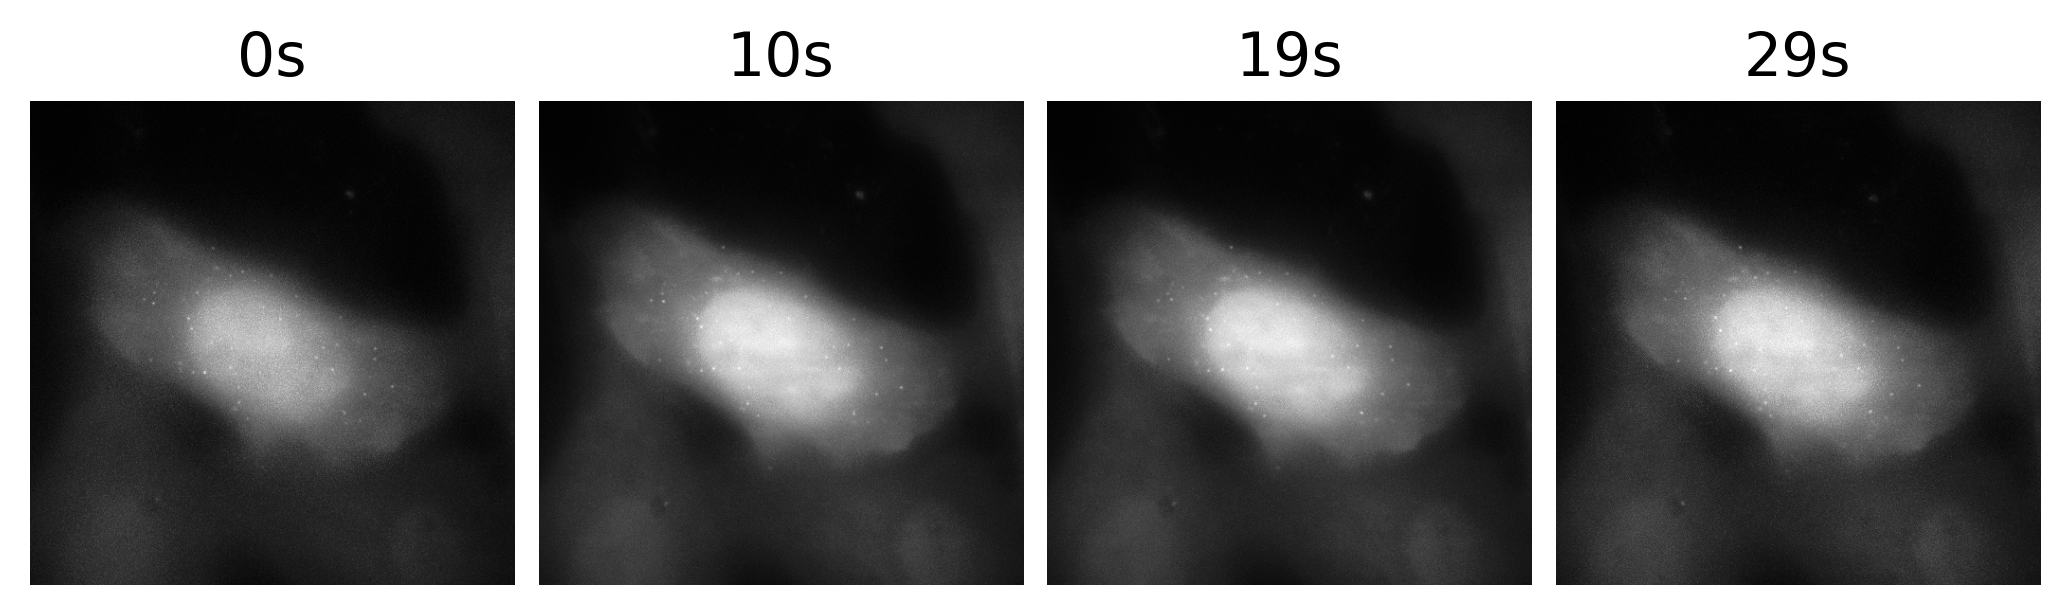

In [10]:
ncrops = 4
time_vector = np.round(np.linspace(0,simulation_time_in_sec-1,ncrops)).astype(int)

ncrops = len(time_vector)
time_vector
channel = 1
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 2))
max_val=[]
min_val=[]
for i in range(0, ncrops):
    temp_img= list_videos[0][time_vector[i],:,:,channel]
    max_val.append(np.amax(temp_img))
    min_val.append(np.amin(temp_img))# running the simulation
print('mean intensity in image: ', np.round(temp_img.mean(),1))


for i in range(0, ncrops):
    axes[i].imshow(list_videos[0][time_vector[i],:,:,channel],cmap='Greys_r', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')
    axes[i].set(title= str(time_vector[i]) + 's')
#name_figure = name_files+'_cells.png'
#figure_directory = str(dropbox_address.joinpath(name_figure ) )

plt.tight_layout() 
plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()